<a href="https://colab.research.google.com/github/YAMINISARASWATHI04/DL-Assignment/blob/main/DL(RMSPROP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andhikawb/fashion-mnist-png")

print("Path to dataset files:", path)

100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1"  # Update with actual path
train_path = os.path.join(dataset_path, "train")


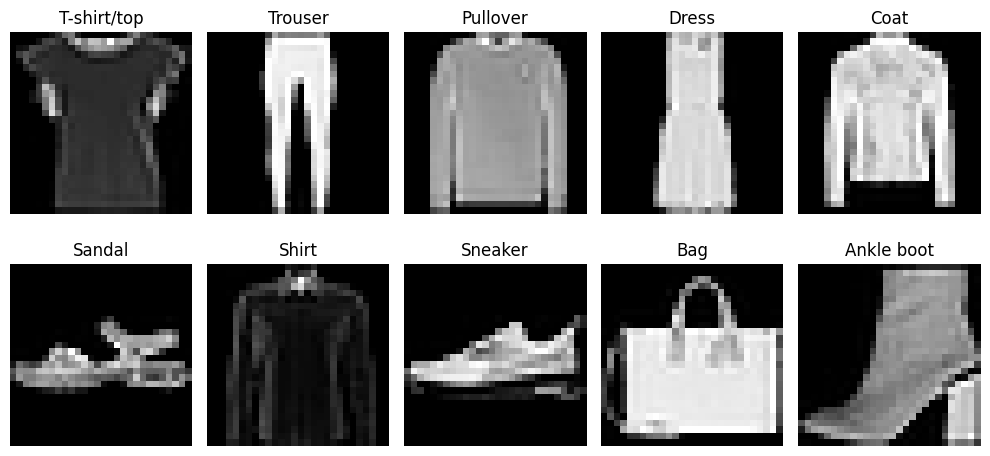

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, label in enumerate(class_labels):
    class_dir = os.path.join(train_path, str(i))
    sample_image = os.listdir(class_dir)[0]
    image_path = os.path.join(class_dir, sample_image)

    img = Image.open(image_path).convert("L")  # Open and convert to grayscale

    ax = axes[i // 5, i % 5]  # Subplot positioning
    ax.imshow(img, cmap="gray")
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [ ]:
# Define transformations (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Split training dataset (90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define class labels
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class FlexibleFNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers=[128, 64], activation="relu", weight_init="xavier"):
        super(FlexibleFNN, self).__init__()

        layers = []
        prev_size = input_size

        # Activation function selection
        if activation == "relu":
            activation_fn = nn.ReLU()
        elif activation == "sigmoid":
            activation_fn = nn.Sigmoid()
        else:
            raise ValueError("Invalid activation function. Choose 'relu' or 'sigmoid'.")

        # Create hidden layers
        for hidden_size in hidden_layers:
            layer = nn.Linear(prev_size, hidden_size)

            # Apply weight initialization
            if weight_init == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif weight_init == "random":
                nn.init.uniform_(layer.weight, -0.1, 0.1)
            else:
                raise ValueError("Invalid weight initialization. Choose 'xavier' or 'random'.")

            layers.append(layer)
            layers.append(activation_fn)
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 10))  # 10 classes

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def get_optimizer(optimizer_name, model_params, learning_rate, weight_decay):
    if optimizer_name == "sgd":
        return optim.SGD(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "momentum":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "nesterov":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif optimizer_name == "rmsprop":
        return optim.RMSprop(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "adam":
        return optim.Adam(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "nadam":
        return optim.NAdam(model_params, lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Invalid optimizer choice.")


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, config_name, num_epochs=10):
    """Train the model and store validation accuracy for each epoch."""
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_accuracies = []  # Store validation accuracy for each epoch
    train_losses = []  # Store training losses for each epoch
    val_losses = []  # Store validation losses for each epoch

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        train_losses.append(total_loss / len(train_loader))

        # Compute Validation Accuracy
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0
        for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Calculate validation loss
                val_loss += loss.item()  # Accumulate validation loss

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_accuracies.append(val_acc)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%, Val Accuracy: {val_acc:.2f}%")

    # Store results for analysis
    experiment_results[config_name] = {
        "val_accuracies": val_accuracies,
        "train_losses": train_losses,  # Store training losses
        "val_losses": val_losses,  # Store validation losses
        "model": model
    }

In [ ]:
experiment_results = {}  # Dictionary to store results

# Define different configurations
configs = [
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64], "activation": "relu", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [64, 32], "activation": "sigmoid", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64], "activation": "sigmoid", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64, 32], "activation": "sigmoid", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},

]

# Train models with different configurations
for config in configs:
    print(f"\nTraining with config: {config}\n")

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = FlexibleFNN(hidden_layers=config["hidden_layers"], activation=config["activation"], weight_init=config["init"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"], weight_decay=0.0005)

    # Access the loss_function key, which is now present
    if config["loss_function"] == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif config["loss_function"] == "mse":
        criterion = nn.MSELoss()
    else:
        raise ValueError("Invalid loss function choice.")

    train_model(model, train_loader, val_loader, optimizer, str(config), num_epochs=10)


Training with config: {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}

Epoch [1/10], Loss: 0.5124, Train Accuracy: 81.31%, Val Accuracy: 85.08%
Epoch [2/10], Loss: 0.4021, Train Accuracy: 85.39%, Val Accuracy: 85.50%
Epoch [3/10], Loss: 0.3745, Train Accuracy: 86.17%, Val Accuracy: 84.75%
Epoch [4/10], Loss: 0.3544, Train Accuracy: 86.84%, Val Accuracy: 84.70%
Epoch [5/10], Loss: 0.3413, Train Accuracy: 87.28%, Val Accuracy: 85.80%
Epoch [6/10], Loss: 0.3327, Train Accuracy: 87.62%, Val Accuracy: 87.78%
Epoch [7/10], Loss: 0.3235, Train Accuracy: 87.99%, Val Accuracy: 84.90%
Epoch [8/10], Loss: 0.3172, Train Accuracy: 88.05%, Val Accuracy: 86.93%
Epoch [9/10], Loss: 0.3115, Train Accuracy: 88.38%, Val Accuracy: 86.28%
Epoch [10/10], Loss: 0.3060, Train Accuracy: 88.55%, Val Accuracy: 85.53%

Training with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': '

In [ ]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

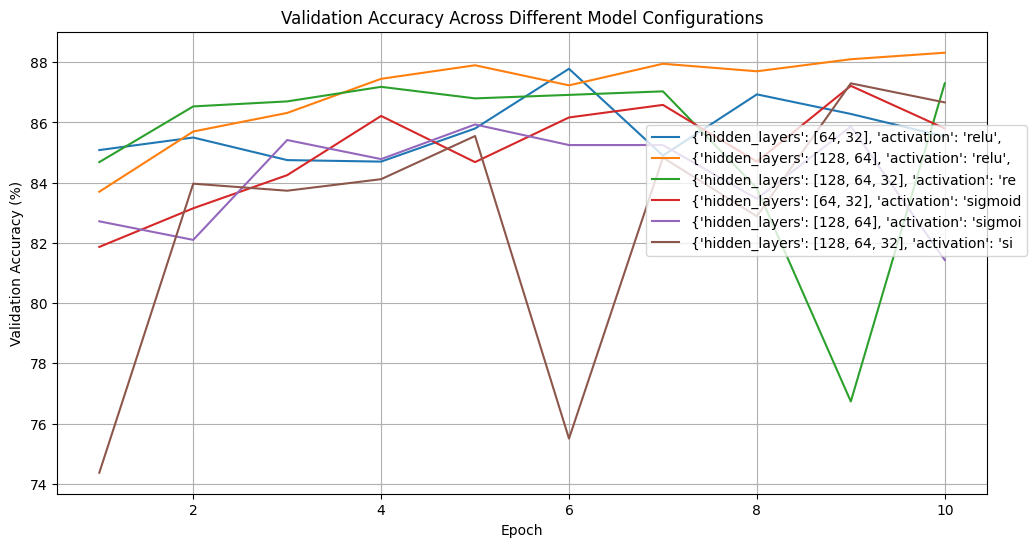

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracy for each experiment
plt.figure(figsize=(12, 6))

for config_name, results in experiment_results.items():  # Access the dictionary with results
    val_acc = results['val_accuracies']  # Access the 'val_accuracies' list
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=config_name[:50])  # Shortened config name

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Different Model Configurations")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5))
plt.grid()
plt.show()

In [ ]:
import torch

def compute_test_accuracy(model, test_loader, device):

    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    test_accuracy = (correct_predictions / total_samples) * 100
    return test_accuracy


In [ ]:
# Dictionary to store test accuracies for each model configuration
test_accuracies = {}

for config_name, model_data in experiment_results.items():
    model = model_data['model']  # Retrieve the trained model
    accuracy = compute_test_accuracy(model, test_loader, device)
    test_accuracies[config_name] = accuracy
    print(f"Test Accuracy for {config_name}: {accuracy:.2f}%")


Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 84.84%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 87.00%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 85.98%
Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 84.81%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 80.61%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'sigmoi

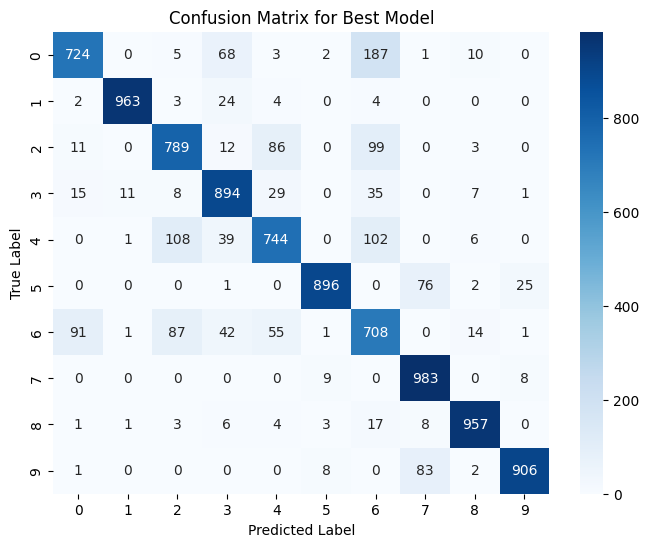

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
experiment_results = {}  # Dictionary to store results

# Define different configurations
configs = [
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64], "activation": "relu", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [64, 32], "activation": "sigmoid", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64], "activation": "sigmoid", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64, 32], "activation": "sigmoid", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},

]

# Train models with different configurations
for config in configs:
    print(f"\nTraining with config: {config}\n")

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = FlexibleFNN(hidden_layers=config["hidden_layers"], activation=config["activation"], weight_init=config["init"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"], weight_decay=0.0005)

    # Access the loss_function key, which is now present
    if config["loss_function"] == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif config["loss_function"] == "mse":
        criterion = nn.MSELoss()
    else:
        raise ValueError("Invalid loss function choice.")

    train_model(model, train_loader, val_loader, optimizer, str(config), num_epochs=10)


Training with config: {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}

Epoch [1/10], Loss: 0.5134, Train Accuracy: 81.31%, Val Accuracy: 84.05%
Epoch [2/10], Loss: 0.4014, Train Accuracy: 85.50%, Val Accuracy: 84.73%
Epoch [3/10], Loss: 0.3706, Train Accuracy: 86.42%, Val Accuracy: 85.17%
Epoch [4/10], Loss: 0.3528, Train Accuracy: 87.17%, Val Accuracy: 85.50%
Epoch [5/10], Loss: 0.3388, Train Accuracy: 87.59%, Val Accuracy: 87.42%
Epoch [6/10], Loss: 0.3286, Train Accuracy: 87.89%, Val Accuracy: 87.15%
Epoch [7/10], Loss: 0.3217, Train Accuracy: 88.07%, Val Accuracy: 87.87%
Epoch [8/10], Loss: 0.3153, Train Accuracy: 88.36%, Val Accuracy: 87.20%
Epoch [9/10], Loss: 0.3090, Train Accuracy: 88.60%, Val Accuracy: 87.87%
Epoch [10/10], Loss: 0.3073, Train Accuracy: 88.67%, Val Accuracy: 84.53%

Training with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'rmsprop', 

In [ ]:
test_accuracies = {}

for config_name, model_data in experiment_results.items():
    model = model_data['model']  # Retrieve the trained model
    accuracy = compute_test_accuracy(model, test_loader, device)
    test_accuracies[config_name] = accuracy
    print(f"Test Accuracy for {config_name}: {accuracy:.2f}%")


Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 82.75%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.46%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.03%
Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 85.72%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.09%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32, 'lr'

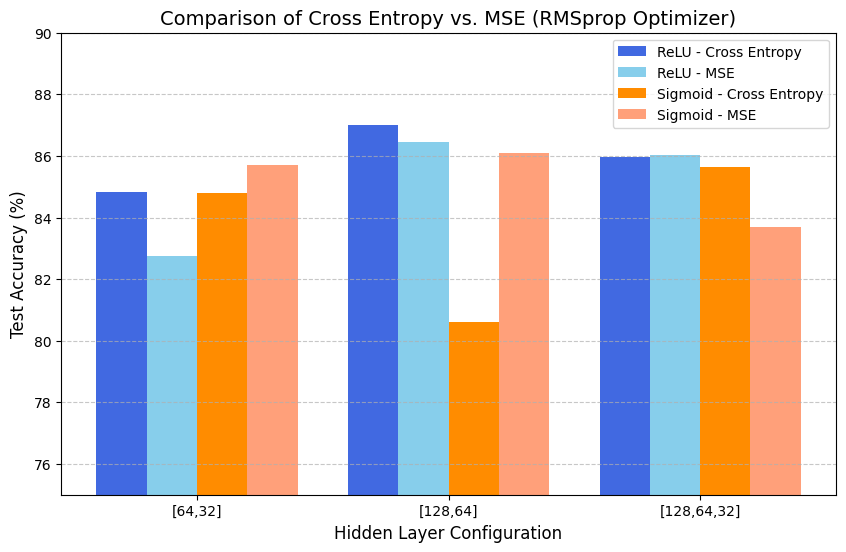

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the test results
hidden_layer_configs = ['[64,32]', '[128,64]', '[128,64,32]']

relu_cross_entropy = [84.84, 87.00, 85.98]
relu_mse = [82.75, 86.46, 86.03]

sigmoid_cross_entropy = [84.81, 80.61, 85.64]
sigmoid_mse = [85.72, 86.09, 83.69]

# Set bar width
bar_width = 0.2
index = np.arange(len(hidden_layer_configs))

# Plot bars
plt.figure(figsize=(10, 6))

plt.bar(index - bar_width, relu_cross_entropy, bar_width, label="ReLU - Cross Entropy", color='royalblue')
plt.bar(index, relu_mse, bar_width, label="ReLU - MSE", color='skyblue')

plt.bar(index + bar_width, sigmoid_cross_entropy, bar_width, label="Sigmoid - Cross Entropy", color='darkorange')
plt.bar(index + 2*bar_width, sigmoid_mse, bar_width, label="Sigmoid - MSE", color='lightsalmon')

# Labels and titles
plt.xlabel("Hidden Layer Configuration", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.title("Comparison of Cross Entropy vs. MSE (RMSprop Optimizer)", fontsize=14)
plt.xticks(index + bar_width / 2, hidden_layer_configs)  # Align x-axis labels
plt.ylim(75, 90)  # Set y-axis limits for better visualization
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [5]:
# Inferences based on the test accuracy results
print("\n----- Inferences from Cross Entropy vs. MSE (RMSprop Optimizer) -----\n")

print("1. ReLU with Cross Entropy achieves the highest accuracy, peaking at 87.00% for [128, 64].")
print("2. ReLU with MSE performs slightly worse than Cross Entropy but still maintains competitive accuracy (~86%).")
print("3. Sigmoid with Cross Entropy struggles with deeper networks, especially at [128, 64] where accuracy drops to 80.61%.")
print("4. Sigmoid with MSE surprisingly outperforms Cross Entropy in some cases, reaching 86.09% for [128, 64].")
print("5. Overall, ReLU with Cross Entropy is the best choice, while Sigmoid benefits more from MSE than Cross Entropy.")



----- Inferences from Cross Entropy vs. MSE (RMSprop Optimizer) -----

1. ReLU with Cross Entropy achieves the highest accuracy, peaking at 87.00% for [128, 64].
2. ReLU with MSE performs slightly worse than Cross Entropy but still maintains competitive accuracy (~86%).
3. Sigmoid with Cross Entropy struggles with deeper networks, especially at [128, 64] where accuracy drops to 80.61%.
4. Sigmoid with MSE surprisingly outperforms Cross Entropy in some cases, reaching 86.09% for [128, 64].
5. Overall, ReLU with Cross Entropy is the best choice, while Sigmoid benefits more from MSE than Cross Entropy.
